In [32]:
# load the deepforest prebuilt crown model and run it on a single image
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import rasterio


In [36]:
model = main.deepforest()

model.use_release()

## load the image
# image_path = get_data("OSBS_029.tif")
# image_path = "/Users/philblecher/Desktop/Github/BioAI/test_imgs/51.png"
image_path = "/Users/philblecher/Desktop/Github/BioAI/test_imgs/example.tif"

# run the model
predictions = model.predict_tile(raster_path=image_path, return_plot=False, patch_size=100, patch_overlap=0.1)
predictions.head()
# plt.imshow(predictions)
# plt.show()



Reading config file: /Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 15/15 [01:26<00:00,  0.17it/s]
619 predictions in overlapping windows, applying non-max supression
399 predictions kept after non-max suppression


,xmin,ymin,xmax,ymax,label,score,image_path
0,57.0,10.0,63.0,17.0,Tree,0.462199,example.tif
1,78.0,85.0,86.0,94.0,Tree,0.416481,example.tif
2,50.0,155.0,55.0,160.0,Tree,0.405475,example.tif
3,26.0,28.0,30.0,32.0,Tree,0.394569,example.tif
4,52.0,164.0,56.0,168.0,Tree,0.387328,example.tif


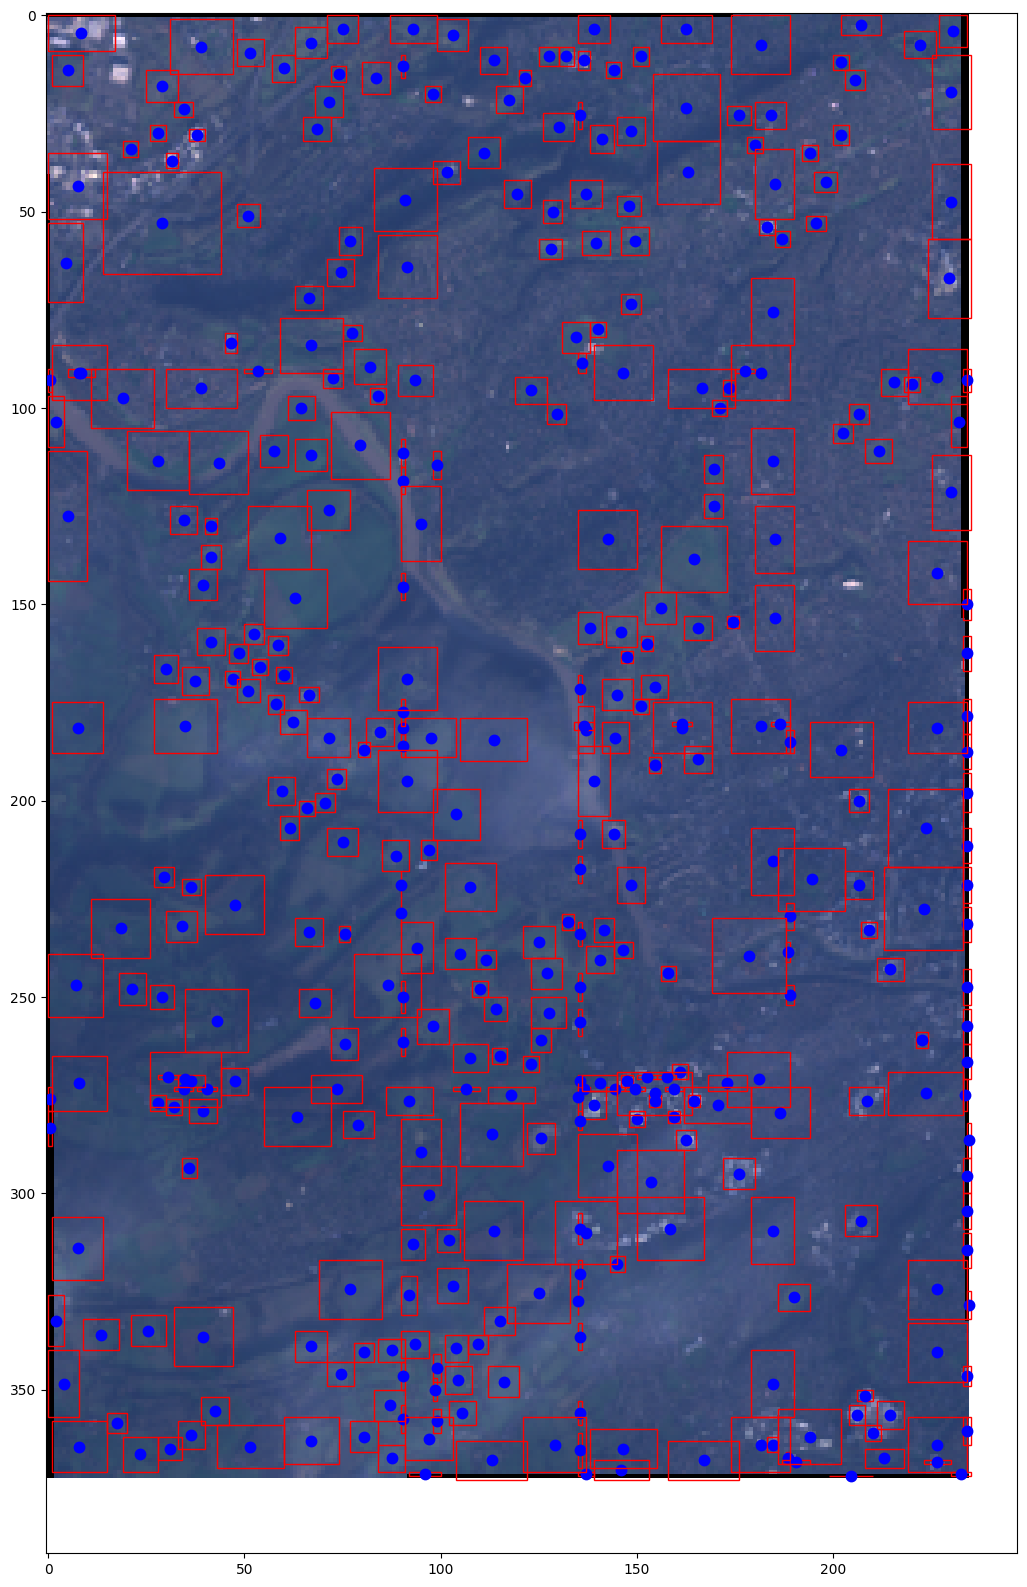

In [40]:
# plot the image .tif and the predictions
fig, ax = plt.subplots(figsize=(20, 20))

# open tif image
image = rasterio.open(image_path)
image = image.read()
image = np.moveaxis(image, 0, -1)
image = image.squeeze()
plt.imshow(image)

# plot the bounding boxes
for i in range(len(predictions)):
    x, y, w, h = predictions["xmin"][i], predictions["ymin"][i], predictions["xmax"][i], predictions["ymax"][i]
    rect = plt.Rectangle((x, y), w-x, h-y, fill=False, color="red")
    ax.add_patch(rect)
    # scatter points on the image, scale the scatter points fit the same scale as the image
    ax.scatter(predictions["xmin"][i] + (predictions["xmax"][i] - predictions["xmin"][i]) / 2,
                predictions["ymin"][i] + (predictions["ymax"][i] - predictions["ymin"][i]) / 2,   
                color="blue", linewidths=2.5, edgecolors="blue")


plt.show()


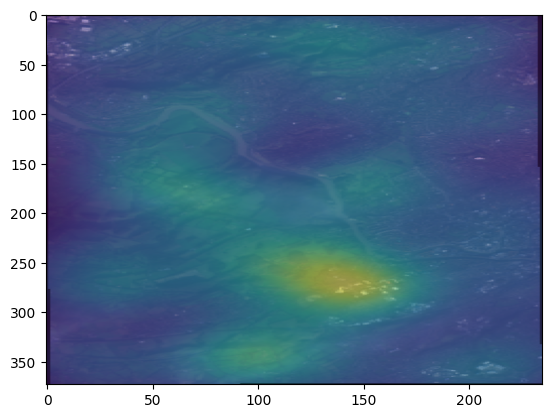

In [42]:
# transform the scatter into a density map
# create a grid of points
x_size = np.linspace(0, image.shape[1], image.shape[1])
y_size = np.linspace(0, image.shape[0], image.shape[0])
X, Y = np.meshgrid(x_size, y_size)
# create a density map
Z = np.zeros(X.shape)
for i in range(len(predictions)):
    x, y = (predictions["xmin"][i] + predictions["xmax"][i]) / 2, (predictions["ymin"][i] + predictions["ymax"][i]) / 2
    Z += np.exp(-((X - x)**2 + (Y - y)**2) / 1000) # the 1000 is a hyperparameter that controls the spread of the density map


fig, ax = plt.subplots()
ax.imshow(Z, aspect="auto")
ax.imshow(image, aspect="auto", alpha=0.5)
plt.show()


(100, 100, 1)
[[ 3.5368993  3.8221924  4.1266723 ...  4.8972163  4.56585    4.2500286]
 [ 3.9343202  4.2575703  4.603146  ...  5.2847323  4.9195814  4.573388 ]
 [ 4.328893   4.6910114  5.0787096 ...  5.62522    5.2273793  4.852394 ]
 ...
 [ 5.156321   5.5388646  5.935596  ... 10.619782  10.040519   9.466437 ]
 [ 4.7201533  5.078203   5.4507823 ... 10.068228   9.50917    8.956896 ]
 [ 4.2667084  4.596584   4.940797  ...  9.400002   8.871179   8.3500185]]


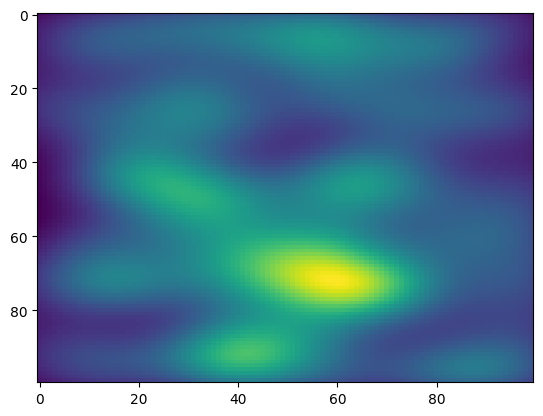

In [52]:
# transform the density map into an array of density values shape (m,n,1)
Z = Z.reshape(Z.shape[0], Z.shape[1], 1)
print(Z.shape)

# resize and interpolate the density map to the same number of pixels as the image as requested
rows = 100
cols = 100
Z = np.array(Image.fromarray(Z.squeeze()).resize((rows, cols)))
print(Z)

# normalize the density map
Z = Z / np.max(Z)

# plot the density map
fig, ax = plt.subplots()
ax.imshow(Z, aspect="auto")
plt.show()




In [54]:
print(Z.shape)

(100, 100)


In [11]:
import ee
ee.Authenticate()

ee.Initialize()
dataset = ee.Image("CGIAR/SRTM90_V4")
elevation = dataset.select("elevation")

# get the bounding box of the image
centre_coords = [ -2.637450, 51.457916]

box_width = 0.005
bounding_box = ee.Geometry.Rectangle([centre_coords[0] - box_width, centre_coords[1] - box_width, centre_coords[0] + box_width, centre_coords[1] + box_width])


# extract satellite image of the area
image_collection = ee.ImageCollection("COPERNICUS/S2")
image_collection = image_collection.filterBounds(bounding_box)
image_collection = image_collection.filterDate("2023-01-01", "2024-12-31")
# image_collection = image_collection.sort()
image = image_collection.first()

# get the image
image = image.visualize(**{
    "bands": ["B4", "B3", "B2"],
    "min": 1000,
    "max": 5000,
})

# resample the image with a resolution of 1m
res = 0.1
image = image.resample("bilinear").reproject(crs= image.projection(), scale=res)


# extract values from the image
image = image.updateMask(image.mask().reduce("min"))


# show the image with ee
print(ee.Image(image).getThumbUrl({
    "region": bounding_box.getInfo()["coordinates"],
    "dimensions": "1500x1500"
}))


elevation_clip = elevation.clip(bounding_box)

res = 10

resampled = elevation_clip.resample("bilinear").reproject(crs= elevation_clip.projection(), scale=res)

opacity = 0.9

vis_params = {
    "min": 0,
    "max": 300,
    "opacity": opacity
}

# get the image
image = resampled.visualize(**vis_params)

# show the image with ee
print(ee.Image(image).getThumbUrl({
    "region": bounding_box.getInfo()["coordinates"],
    "dimensions": "1500x1500"
}))



True